- Recency: 마지막 구매일이 언제 인가
- Frequency: 얼마나 자주 구매했는가
- Monetary: 구매 금액이 얼마나 되는가

# 1.데이터 로드

In [150]:
import pandas as pd

data = pd.read_csv("data/CDNOW_master.txt",header = None, names = ['cid','pdate','numCDs','amount'])

data.head(3)

,cid,pdate,numCDs,amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00


# 2.데이터 정제

In [151]:
#날짜 정제
data['pdate'] = pd.to_datetime(data['pdate'], format = "%Y%m%d")

#주문 아이디 생성
data['oid'] = data.index

data.sample(3)

,cid,pdate,numCDs,amount,oid
14312,4485,1997-03-04,4,30.52,14312
59012,19716,1997-12-10,4,56.46,59012
25562,8144,1997-06-14,1,27.77,25562


# 3.고객 유지율 표

월별 고객이 얼마나 유지되었나 **코호트 분석**을 해보자

In [152]:
# 연-월 데이터
data['OrderPeriod'] = data['pdate'].apply(lambda x: x.strftime('%Y-%m'))

# 첫 주문 데이터
data.set_index('cid',inplace = True)

data['CohortGroup'] = data.groupby(level=0)['pdate'].min().apply(lambda x: x.strftime('%Y-%m'))
data.reset_index(inplace = True)

data.head()

,cid,pdate,numCDs,amount,oid,OrderPeriod,CohortGroup
0,1,1997-01-01,1,11.77,0,1997-01,1997-01
1,2,1997-01-12,1,12.00,1,1997-01,1997-01
2,2,1997-01-12,5,77.00,2,1997-01,1997-01
3,3,1997-01-02,2,20.76,3,1997-01,1997-01
4,3,1997-03-30,2,20.76,4,1997-03,1997-01


In [153]:
import numpy as np

grouped = data.groupby(['CohortGroup','OrderPeriod'])

cohorts = grouped.agg({'cid':pd.Series.nunique,
                       'oid':pd.Series.nunique,
                       'amount':np.sum})

cohorts.rename(columns={'cid':'TotalUsers',
                        'oid':'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders     amount
CohortGroup OrderPeriod                                    
1997-01     1997-01            7846         8928  299060.17
            1997-02            1157         1627   61041.69
            1997-03             964         1329   50683.75
            1997-04             810         1091   40655.50
            1997-05             679          904   34973.56

In [154]:
def cohort_period(data):
    data['CohortPeriod'] = np.arange(len(data))+1
    return data

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders     amount  CohortPeriod
CohortGroup OrderPeriod                                                  
1997-01     1997-01            7846         8928  299060.17             1
            1997-02            1157         1627   61041.69             2
            1997-03             964         1329   50683.75             3
            1997-04             810         1091   40655.50             4
            1997-05             679          904   34973.56             5

In [155]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
1997-01    7846
1997-02    8476
1997-03    7248
Name: TotalUsers, dtype: int64

In [156]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
1997-01      1               7846
             2               1157
             3                964
             4                810
             5                679
Name: TotalUsers, dtype: int64

In [157]:
cohorts['TotalUsers'].unstack(0).head()


CohortGroup,1997-01,1997-02,1997-03
CohortPeriod,,,
1,7846.0,8476.0,7248.0
2,1157.0,1312.0,1032.0
3,964.0,980.0,752.0
4,810.0,783.0,756.0
5,679.0,847.0,674.0


In [158]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,1997-01,1997-02,1997-03
CohortPeriod,,,
1,1.000000,1.000000,1.000000
2,0.147464,0.154790,0.142384
3,0.122865,0.115621,0.103753
4,0.103237,0.092378,0.104305
5,0.086541,0.099929,0.092991
6,0.093806,0.092732,0.077815
7,0.091767,0.073856,0.077401
8,0.074178,0.073030,0.079884
9,0.071246,0.078575,0.087472


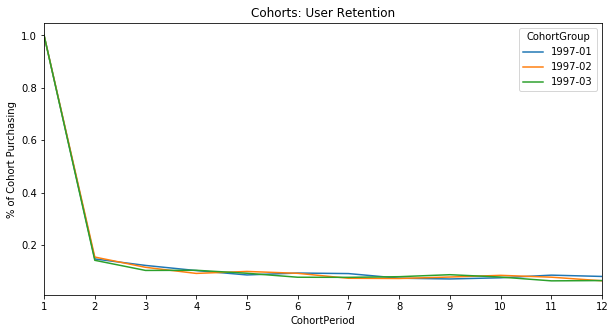

In [161]:
user_retention[['1997-01', '1997-02', '1997-03']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

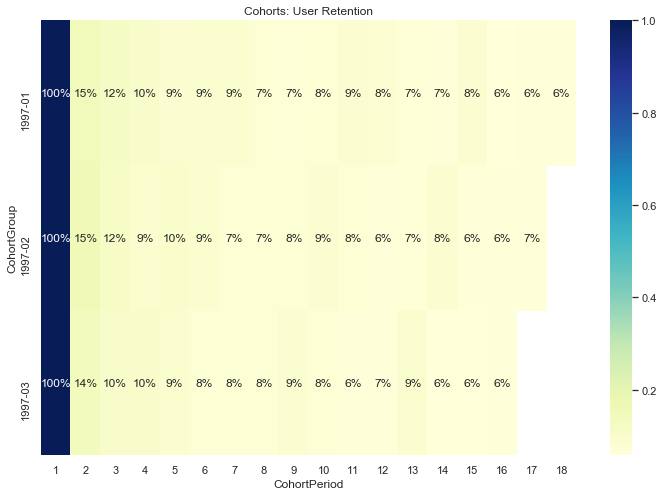

In [163]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', cmap="YlGnBu");

[알엠에프](https://statkclee.github.io/ml/ml-pm-applications.html) <br>
[코호트](http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/)